# II. MACHINE LEARNING CLASSIFICATION

### Libraries

In [20]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [21]:
import numpy as np
import pandas as pd
from scipy import stats
import re
import random

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.pylab import rcParams
from ipywidgets import interact

from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


### Functions:

In [22]:
def model_fit_predict(model):
    '''
    Fit the model and predict over X_train and X_test
    '''
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    return y_pred_train, y_pred_test, model

In [23]:
def reports(y_pred_train, y_pred_test):
    '''
    Confusion matrix and classification report on train and test sets
    '''
    print('Confussion Matrix for train data:\n\n{}'.format(confusion_matrix(y_train, 
                                                                      y_pred_train)))
    print('\nClassification report for train data:\n\n{}'.format(classification_report(y_train, 
                                                                      y_pred_train)))
    print('\nConfussion Matrix for test data:\n\n{}'.format(confusion_matrix(y_test, 
                                                                      y_pred_test)))
    print('\nClassification report for test data:\n\n{}'.format(classification_report(y_test,
                                                                      y_pred_test)))

In [24]:
class estimation_selector_helper:
    '''
    Grid search and score summary
    '''

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False): 
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [25]:
def feature_importances(model, df):
    """
    Plot feature importances of the model.
    """
    features = df.columns[model.feature_importances_.argsort()]
    model.feature_importances_.sort()
    plt.figure(figsize=(15,15))
    n_features = len(features)
    plt.title("Feature importances")
    plt.barh(range(n_features), np.sort(model.feature_importances_),
             color='b',
             align='center')
    plt.yticks(np.arange(n_features), features)
    plt.xlabel("Relative Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

## 1. Baseline Approach:

When dealing with Data Science problems, we may have no idea of how hard a problem is going to be. This is, we can try our model, get some metrics, but still, we have no idea of how good or bad our results are, this is why we use a baseline.
A baseline can be a previous result from a different model or a simple rule to classify our samples (for example, in a regression problem it's typical tu use the mean).

In this problem, there is one value that is constant during a game and that we know beforehand: the ELO difference between players (`diff_rating`). As we saw when we did the data exploration, the players with the highest rating won more games on average, so we will use this approach as a baseline and predict the winner based on rating difference. Let's see what we get.

*Note: as we are dealing with a binary classification problem, we also know that the worst accuracy we can have is 0.5 (like flipping a coin), so we can also use this information in case our model is extremely bad.

### a. Gathering Data:

In this file we are going to work with the preprocessed data that we prepared in the `EDA AND PREPARATION` section. Let's take a quick look!

In [26]:
df = pd.read_csv('prepared_data.csv')
print('prepared_data:\nRows: {}\nColumns: {}'.format(df.shape[0], df.shape[1]))

prepared_data:
Rows: 1707161
Columns: 53


In [27]:
df.head()

,match_id,current_time,timestamp,diff_units_infantry,diff_units_ranged,diff_units_siege,diff_units_war_ships,diff_units_cavalry_archers,diff_units_cavalry,diff_units_monks,...,diff_castles,diff_score_military,diff_score_economy,diff_score_technology,diff_score_society,diff_score_total,diff_kills,diff_razes,player_1_wins,diff_rating
0,16720609,0,0,-1,0,0,0,0,1,0,...,0,0,2,0,0,2,0,0,0,43
1,16720609,3,1,-1,0,0,0,0,1,0,...,0,0,2,0,0,2,0,0,0,43
2,16720609,6,2,-1,0,0,0,0,1,0,...,0,0,22,0,0,22,0,0,0,43
3,16720609,9,3,-1,0,0,0,0,1,0,...,0,0,25,0,0,25,0,0,0,43
4,16720609,12,4,-1,0,0,0,0,1,0,...,0,0,28,0,0,28,0,0,0,43


### b. Data Sampling:

After gathering our data, we will do some sampling. For the type of problem we face, we have to be careful when choosing a sample on which to apply our models, we cannot simply select a random sample, we have to choose complete games since there are interdependencies between rows of the same game. 

In [28]:
#choose the number of matches and the proportion of train and validation samples
n_matches = 1000
train_size = 0.5
val_size = 0.2

#list unique game identifiers
ids_list = list(df['match_id'].unique())
print('Different games: {}'.format(len(ids_list)))

#sample matches at random
ids_sample_list = random.sample(ids_list, n_matches)
print('Games selected as sample: {}'.format(len(ids_sample_list)))

Different games: 2077
Games selected as sample: 1000


### c. Train-Validation-Test Splits:


Then we proceed with the separation between training, validation and testing sets:

In [29]:
#split into train, validation and test

ids_train_list = ids_sample_list[:int(n_matches*train_size)]
ids_val_list = ids_sample_list[int(n_matches*train_size):int(n_matches*(train_size+val_size))]
ids_test_list = ids_sample_list[int(n_matches*(train_size+val_size)):]

print('Train games: ',len(ids_train_list))
print('Validation games: ',len(ids_val_list))
print('Test games: ',len(ids_test_list))

#split into two dataframes filtering by match_id
df_train = df[df['match_id'].isin(ids_train_list)]
df_val = df[df['match_id'].isin(ids_val_list)]
df_test = df[df['match_id'].isin(ids_test_list)]

print('\nTrain samples: ',len(df_train))
print('Validation samples: ',len(df_val))
print('Test samples: ',len(df_test))

Train games:  500
Validation games:  200
Test games:  300

Train samples:  415442
Validation samples:  164280
Test samples:  247702


### d. Data Balancing:

Here, data balancing is not necessary. We have almost the same amount of games won by player 1 than by player 2 and the results are arbitrary (player 1 is assigned at random), as we saw when doing data exploration. This question is more important for other type of problems, anyway, we'll plot it.

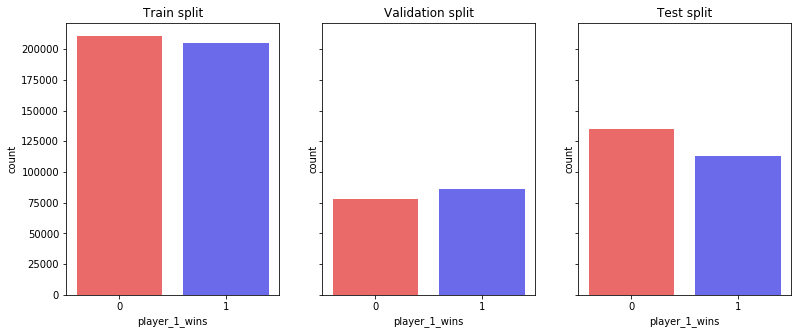

In [30]:
fig, ax =plt.subplots(1,3,figsize=(13,5), sharey=True) 
ax[0].set_title('Train split')
ax[1].set_title('Validation split')
ax[2].set_title('Test split')
sns.countplot(df_train.player_1_wins, palette='seismic_r', ax=ax[0])
sns.countplot(df_val.player_1_wins, palette='seismic_r', ax=ax[1])
sns.countplot(df_test.player_1_wins, palette='seismic_r', ax=ax[2])
fig.show()

### e. X-y Split:

Here we split our data into independent (X) and dependent features(y):

In [31]:
#get the X and y train from the train dataframe
X_train = df_train.drop(['match_id', 'current_time', 'player_1_wins'], axis=1)
y_train = df_train['player_1_wins']

#get the X and y validation from the validation dataframe
X_val = df_val.drop(['match_id', 'current_time', 'player_1_wins'], axis=1)
y_val = df_val['player_1_wins']

#get the X and y test from the test dataframe
X_test = df_test.drop(['match_id', 'current_time', 'player_1_wins'], axis=1)
y_test = df_test['player_1_wins']

print('X_train shape: {}\ny_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}\ny_val shape: {}'.format(X_test.shape, y_test.shape))
print('X_test shape: {}\ny_test shape: {}'.format(X_test.shape, y_test.shape))

X_train shape: (415442, 50)
y_train shape: (415442,)
X_val shape: (247702, 50)
y_val shape: (247702,)
X_test shape: (247702, 50)
y_test shape: (247702,)


### f. Data Scaling:

Here we'll apply feature scaling, a technique to standardize the independent variables present in the data to avoid noise in our models. We have to be careful when fitting the scaler, we'll use only train samples so as not to incur overfitting.

In [32]:
#fit the scaler (only train samples)
std_scaler = StandardScaler()
std_scaler.fit(X_train)

#transform the data
X_train = std_scaler.transform(X_train)
X_val = std_scaler.transform(X_val)
X_test = std_scaler.transform(X_test)

#we could try the MinMaxScaler also, but it's not really important.

### g. Results:

Finally we can already test our baseline approach, as we expected, the classification slightly improves the minimum of 50% (random choice) when we consider the `diff_ranking` feature.

In [33]:
# We only have one row for each game here
df_test_baseline = df_test[['match_id', 'diff_rating', 'player_1_wins']].drop_duplicates()

df_test_baseline['pred'] = df_test_baseline['diff_rating'] > 0
df_test_baseline['right'] = df_test_baseline['pred'] == df_test_baseline['player_1_wins']

print('Baseline accuracy: ',np.mean(df_test_baseline['right'])) # Accuracy

Baseline accuracy:  0.5366666666666666


## 2. Machine Learning Models:

In this section we'll train and test our models. First, we will test a logistic regression and a random forest for the default parameters, and then we will do a gridsearch for the following models:

- LogisticRegression Classifier
- RandomForest Classifier
- Adaboost Classifier
- Gradientboosting Classifier

Finally we'll test previous models (+others) on a gridsearch with crossvalidation for a sample of 30,000 randomly selected instances from our dataset.

### a. Logistic Regression:

Sklearn logistic regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [34]:
y_pred_train, y_pred_test, logreg = model_fit_predict(LogisticRegression())

In [35]:
reports(y_pred_train, y_pred_test)

Confussion Matrix for train data:

[[157634  52954]
 [ 58199 146655]]

Classification report for train data:

              precision    recall  f1-score   support

           0       0.73      0.75      0.74    210588
           1       0.73      0.72      0.73    204854

    accuracy                           0.73    415442
   macro avg       0.73      0.73      0.73    415442
weighted avg       0.73      0.73      0.73    415442


Confussion Matrix for test data:

[[87929 46792]
 [33041 79940]]

Classification report for test data:

              precision    recall  f1-score   support

           0       0.73      0.65      0.69    134721
           1       0.63      0.71      0.67    112981

    accuracy                           0.68    247702
   macro avg       0.68      0.68      0.68    247702
weighted avg       0.68      0.68      0.68    247702



With a quick model like Logistic Regression we get an accuracy on both sets (train and test) of 73%.

### b. Random Forest:

Sklearn random forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        
*Note: RF is a very easy to tune model, the number of trees parameter is not so critical as long as it's big enough.
        

In [36]:
y_pred_train, y_pred_test, rfor = model_fit_predict(RandomForestClassifier())

In [37]:
reports(y_pred_train, y_pred_test)

Confussion Matrix for train data:

[[210564     24]
 [    32 204822]]

Classification report for train data:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    210588
           1       1.00      1.00      1.00    204854

    accuracy                           1.00    415442
   macro avg       1.00      1.00      1.00    415442
weighted avg       1.00      1.00      1.00    415442


Confussion Matrix for test data:

[[90220 44501]
 [29944 83037]]

Classification report for test data:

              precision    recall  f1-score   support

           0       0.75      0.67      0.71    134721
           1       0.65      0.73      0.69    112981

    accuracy                           0.70    247702
   macro avg       0.70      0.70      0.70    247702
weighted avg       0.71      0.70      0.70    247702



We get a very similar precision with a Random Forest with the default parameters.

### c. Grid Search:

Here we are going to tune some of the parameters for the above mentioned models. We are going to test the models with the validation set created previously and we will analyze how the accuracy improves as the games progress.

**LogisticRegression Classifier:**

In [38]:
rang_C = [0.01, 0.1, 1, 10, 100]

vect_tr=[]
vect_val=[]

for C in rang_C:
    #create a classifier, train it and compute training and error accuracies.
    clf = LogisticRegression(C=C)
    clf.fit(X_train, y_train)
    acc_tr = clf.score(X_train, y_train)
    acc_val = clf.score(X_val, y_val)
        
    #saving accuracies in a list 
    vect_tr.append(acc_tr)
    vect_val.append(acc_val)

    print("For C = %2.2f, train accuracy is %2.2f%% and test accuracy is %2.2f%%" 
          % (C, 100*acc_tr, 100*acc_val))


For C = 0.01, train accuracy is 73.25% and test accuracy is 74.66%
For C = 0.10, train accuracy is 73.24% and test accuracy is 74.66%
For C = 1.00, train accuracy is 73.24% and test accuracy is 74.61%
For C = 10.00, train accuracy is 73.25% and test accuracy is 74.60%
For C = 100.00, train accuracy is 73.25% and test accuracy is 74.60%


**Model Evaluation:**

As we are dealing with models that work with time series for each game, we may be interested in the performance of the model at different stages of the game. The intuition tells us that, at the beggining of the game, the accuraacy is going to be low, since we just have `diff_rating` feature (our baseline), but this should improve the later in the game we are.

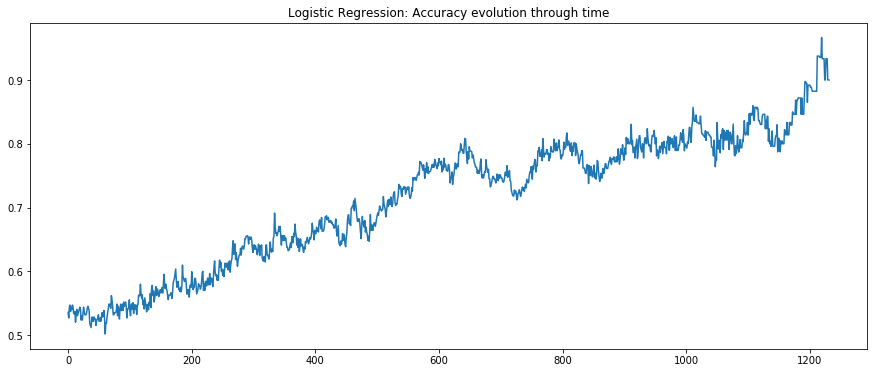

In [39]:
#fit the model with best parameters:
clf = LogisticRegression(C=0.10)
clf.fit(X_train, y_train)

#get the prediction over X_test
y_pred_test = clf.predict(X_test)

#add the 'pred' and 'right' columns that tells us if the prediction was correct
df_test['pred_logreg'] = y_pred_test
df_test['correct_logreg'] = df_test['player_1_wins'] == df_test['pred_logreg']

#group by timestamps and get the total number of games that reached that point and the number of correct predictions in that 
#instant of the game
df_ts_logreg = df_test.groupby('timestamp')['correct_logreg'].agg(['sum','count']).rename(columns={'count':'n_matches', 'sum': 'n_correct'}).reset_index()

#get the accuracy for each TS
df_ts_logreg['acc_logreg'] = df_ts_logreg['n_correct'] / df_ts_logreg['n_matches']

#filter when there's less than 30 matches left with the given duration
df_ts_logreg = df_ts_logreg[df_ts_logreg['n_matches'] >= 30]

#plot the evolution of the accuracy through time
rcParams['figure.figsize'] = 15, 6
plt.title('Logistic Regression: Accuracy evolution through time')
plt.plot(df_ts_logreg['timestamp'], df_ts_logreg['acc_logreg']);

**RandomForest Classifier:**

In [40]:
n_estimators = [100, 200, 500]

vect_tr=[]
vect_val=[]

for n in n_estimators:
    #create a classifier, train it and compute training and error accuracies.
    clf = RandomForestClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    acc_tr = clf.score(X_train, y_train)
    acc_val = clf.score(X_val, y_val)
        
    #saving accuracies in a list 
    vect_tr.append(acc_tr)
    vect_val.append(acc_val)

    print("For n_estimators = %d, train accuracy is %2.2f%% and test accuracy is %2.2f%%" 
          % (n, 100*acc_tr, 100*acc_val))

For n_estimators = 100, train accuracy is 99.99% and test accuracy is 76.18%
For n_estimators = 200, train accuracy is 99.99% and test accuracy is 76.27%
For n_estimators = 500, train accuracy is 99.99% and test accuracy is 76.50%


**Model Evaluation:**

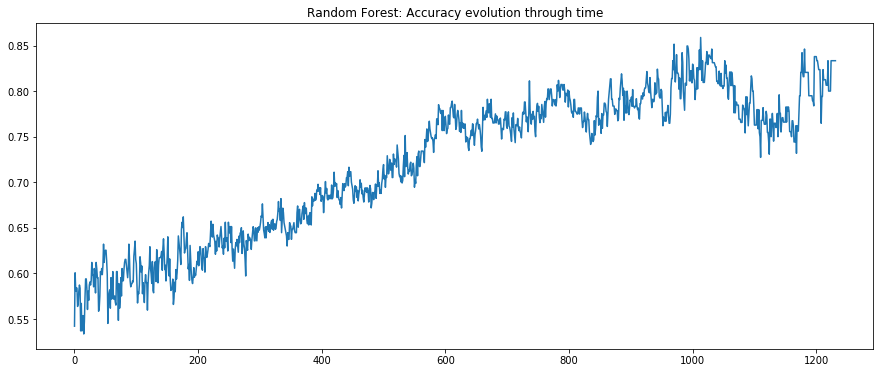

In [41]:
#fit the model with best parameters:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

#get the prediction over X_test
y_pred_test = clf.predict(X_test)

#add the 'pred' and 'right' columns that tells us if the prediction was correct
df_test['pred_ranfor'] = y_pred_test
df_test['correct_ranfor'] = df_test['player_1_wins'] == df_test['pred_ranfor']

#group by timestamps and get the total number of games that reached that point and the number of correct predictions in that 
#instant of the game
df_ts_ranfor = df_test.groupby('timestamp')['correct_ranfor'].agg(['sum','count']).rename(columns={'count':'n_matches', 'sum': 'n_correct'}).reset_index()

#get the accuracy for each TS
df_ts_ranfor['acc_ranfor'] = df_ts_ranfor['n_correct'] / df_ts_ranfor['n_matches']

#filter when there's less than 30 matches left with the given duration
df_ts_ranfor = df_ts_ranfor[df_ts_ranfor['n_matches'] >= 30]

#plot the evolution of the accuracy through time

plt.title('Random Forest: Accuracy evolution through time')
plt.plot(df_ts_ranfor['timestamp'], df_ts_ranfor['acc_ranfor']);

A random forest allows us to quickly visualize the variables that the model has defined as most important, in our case they are (top 5):

- `diff_rating`
- `diff_score_total`
- `diff_score_technology`
- `diff_total_resources_food`
- `diff_score_economy`

Then, we can realize that the rating is very important, as well as scoring variables.

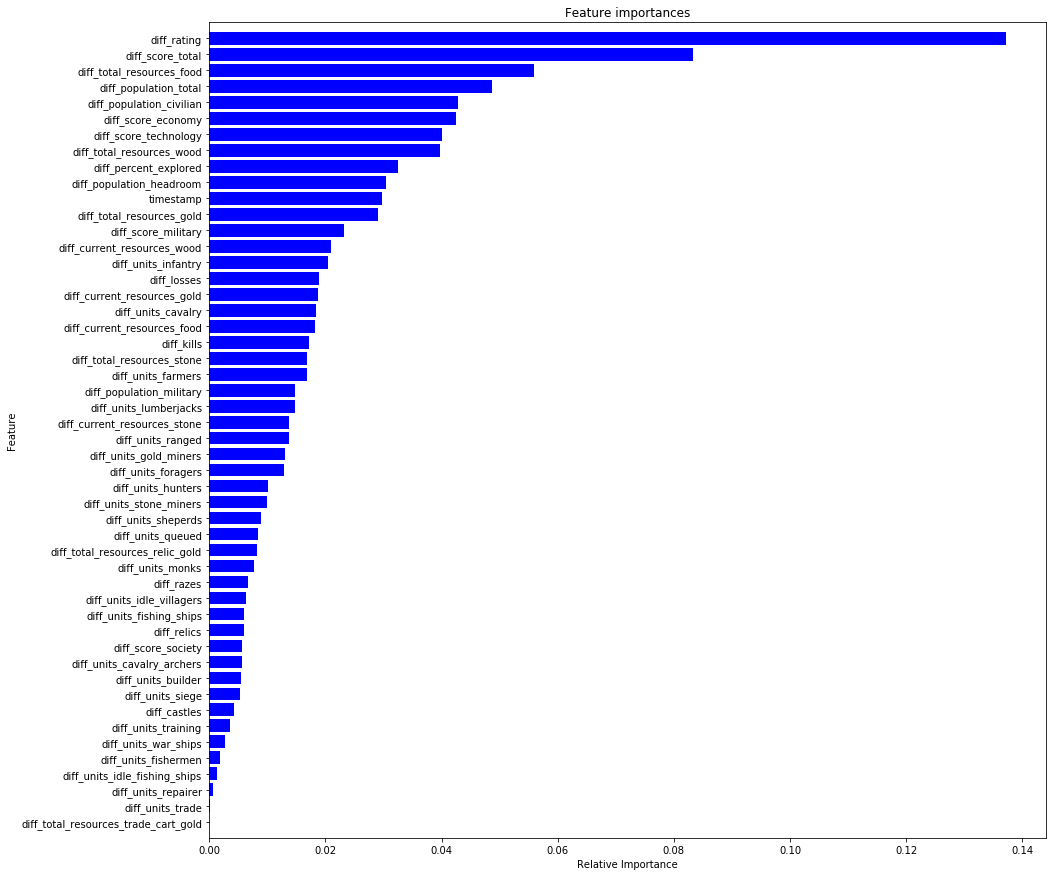

In [42]:
cols_drop = ['match_id', 'current_time', 'player_1_wins']
feature_importances(clf, df.drop(cols_drop, axis=1))

In [43]:
#selecting most important features (assumption)
impfeat = df[['match_id', 'timestamp','player_1_wins',
              'diff_score_total','diff_score_technology',
             'diff_total_resources_food','diff_score_economy', 
             'diff_population_total']]


#displaying most important features evolution for any match
@interact
def match_plots(match=list(impfeat.match_id.unique())):   
    
    #selecting match
    match_data_df = impfeat.loc[impfeat['match_id'] == match]
    
    #scaling
    scaler = MinMaxScaler(feature_range=(-1, 1))
    cols = ['diff_population_total','diff_score_total','diff_score_technology',
             'diff_total_resources_food','diff_score_economy']
    match_data_df[cols] = scaler.fit_transform(match_data_df[cols])

    #ploting
    #we don't plot 'diff_rating' because it's a constant value, we plot 'diff_population instead' 
    plt.figure(figsize=(17,8))
    plt.plot( 'timestamp', 'diff_score_total', data=match_data_df,
             color='b')
    plt.plot( 'timestamp', 'diff_score_technology', data=match_data_df,
             color='g')
    plt.plot( 'timestamp', 'diff_total_resources_food', data=match_data_df,
             color='orange')
    plt.plot( 'timestamp', 'diff_score_economy', data=match_data_df,
             color='grey')
    plt.plot( 'timestamp', 'diff_population_total', data=match_data_df, 
             color='r')
    plt.title('Most important features')
    plt.legend()
    
    if match_data_df.player_1_wins.mean() == 1:
        print(' Player 1 won')
    else:
        print(' Player 1 lost')

interactive(children=(Dropdown(description='match', options=(16720609, 16720612, 16720613, 16720615, 16720616,…

**AdaBoost Classifier:**

Sklearn adaboost: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [44]:
n_estimators = [10, 50, 100]

vect_tr=[]
vect_val=[]

for n in n_estimators:
    #create a classifier, train it and compute training and error accuracies.
    clf = AdaBoostClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    acc_tr = clf.score(X_train, y_train)
    acc_val = clf.score(X_val, y_val)
        
    #saving accuracies in a list 
    vect_tr.append(acc_tr)
    vect_val.append(acc_val)

    print("For n_estimators = %d, train accuracy is %2.2f%% and test accuracy is %2.2f%%" 
          % (n, 100*acc_tr, 100*acc_val))

For n_estimators = 10, train accuracy is 73.39% and test accuracy is 72.37%
For n_estimators = 50, train accuracy is 77.19% and test accuracy is 74.83%
For n_estimators = 100, train accuracy is 79.70% and test accuracy is 74.43%


**Model Evaluation:**

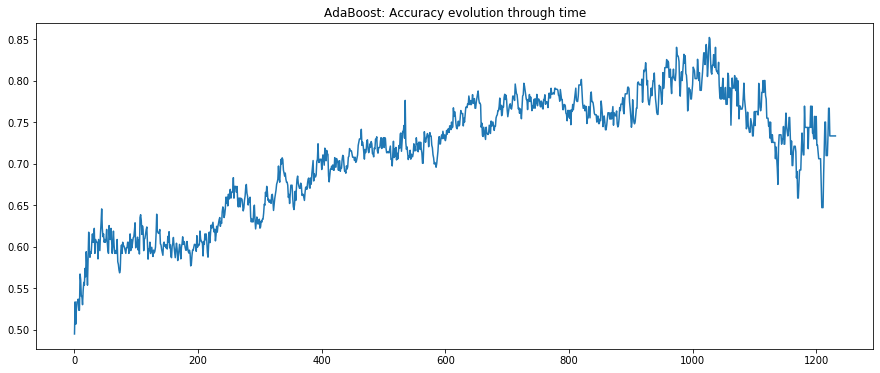

In [45]:
#fit the model with best parameters:
clf =AdaBoostClassifier(n_estimators=50)
clf.fit(X_train, y_train)

#get the prediction over X_test
y_pred_test = clf.predict(X_test)

#add the 'pred' and 'right' columns that tells us if the prediction was correct
df_test['pred_adaboo'] = y_pred_test
df_test['correct_adaboo'] = df_test['player_1_wins'] == df_test['pred_adaboo']

#group by timestamps and get the total number of games that reached that point and the number of correct predictions in that 
#instant of the game
df_ts_adaboo = df_test.groupby('timestamp')['correct_adaboo'].agg(['sum','count']).rename(columns={'count':'n_matches', 'sum': 'n_correct'}).reset_index()

#get the accuracy for each TS
df_ts_adaboo['acc_adaboo'] = df_ts_adaboo['n_correct'] / df_ts_adaboo['n_matches']

#filter when there's less than 30 matches left with the given duration
df_ts_adaboo = df_ts_adaboo[df_ts_adaboo['n_matches'] >= 30]

#plot the evolution of the accuracy through time
plt.title('AdaBoost: Accuracy evolution through time')
plt.plot(df_ts_adaboo['timestamp'], df_ts_adaboo['acc_adaboo']);

**GradientBoosting Classifier:**

Sklearn gradientboosting: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier

In [46]:
n_estimators = [10, 50, 100]
learning_rate = [0.8, 1.0]

vect_tr=[]
vect_val=[]

for n in n_estimators:
    for rate in learning_rate:
        #create a classifier, train it and compute training and error accuracies.
        clf = GradientBoostingClassifier(n_estimators=n,learning_rate=rate)
        clf.fit(X_train, y_train)
        acc_tr = clf.score(X_train, y_train)
        acc_val = clf.score(X_val, y_val)
        
        #saving accuracies in a list 
        vect_tr.append(acc_tr)
        vect_val.append(acc_val)

        print("For n_estimators = %d and for learning_rate = %2.2f, train accuracy is %2.2f%% and test accuracy is %2.2f%%"
              % (n, rate, 100*acc_tr, 100*acc_val))

For n_estimators = 10 and for learning_rate = 0.80, train accuracy is 79.02% and test accuracy is 73.25%
For n_estimators = 10 and for learning_rate = 1.00, train accuracy is 80.40% and test accuracy is 74.46%
For n_estimators = 50 and for learning_rate = 0.80, train accuracy is 90.68% and test accuracy is 71.15%
For n_estimators = 50 and for learning_rate = 1.00, train accuracy is 91.30% and test accuracy is 70.13%
For n_estimators = 100 and for learning_rate = 0.80, train accuracy is 94.77% and test accuracy is 72.16%
For n_estimators = 100 and for learning_rate = 1.00, train accuracy is 95.66% and test accuracy is 70.55%


**Model Evaluation:**

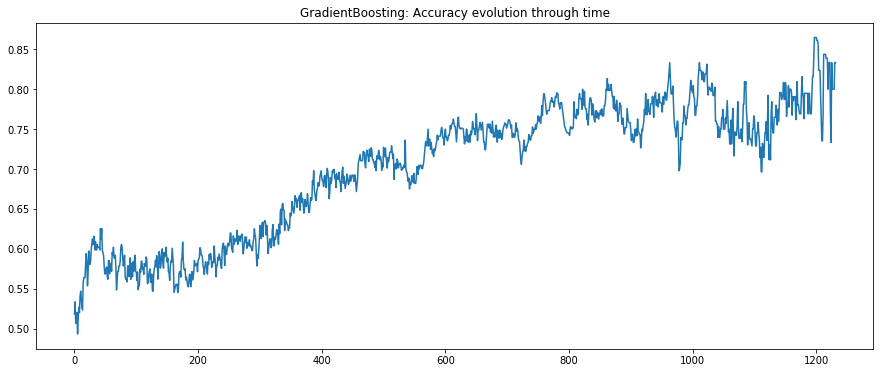

In [47]:
#fit the model with best parameters:
clf =GradientBoostingClassifier(n_estimators=10, learning_rate=0.8)
clf.fit(X_train, y_train)

#get the prediction over X_test
y_pred_test = clf.predict(X_test)

#add the 'pred' and 'right' columns that tells us if the prediction was correct
df_test['pred_graboo'] = y_pred_test
df_test['correct_graboo'] = df_test['player_1_wins'] == df_test['pred_graboo']

#group by timestamps and get the total number of games that reached that point and the number of correct predictions in that 
#instant of the game
df_ts_graboo = df_test.groupby('timestamp')['correct_graboo'].agg(['sum','count']).rename(columns={'count':'n_matches', 'sum': 'n_correct'}).reset_index()

#get the accuracy for each TS
df_ts_graboo['acc_graboo'] = df_ts_graboo['n_correct'] / df_ts_graboo['n_matches']

#filter when there's less than 30 matches left with the given duration
df_ts_graboo = df_ts_graboo[df_ts_graboo['n_matches'] >= 30]

#plot the evolution of the accuracy through time
plt.title('GradientBoosting: Accuracy evolution through time')
plt.plot(df_ts_graboo['timestamp'], df_ts_graboo['acc_graboo']);

**Results:**

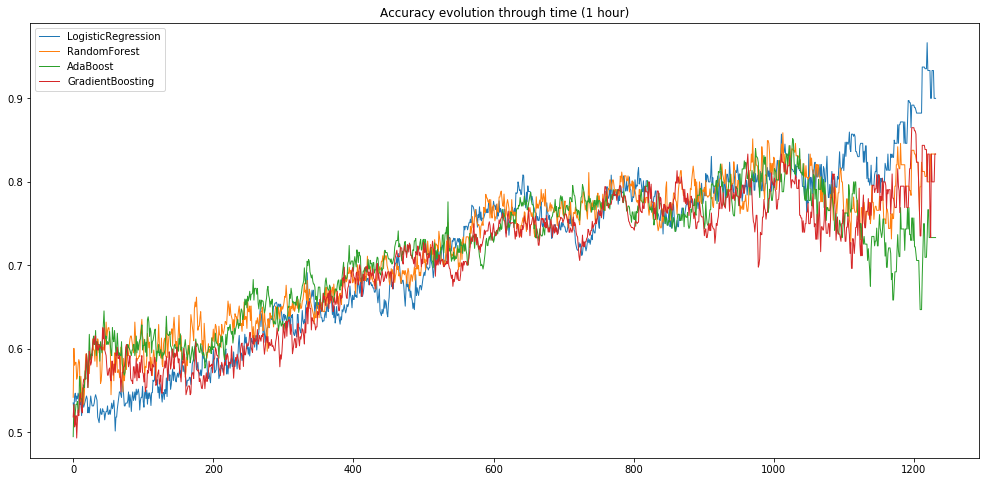

In [48]:
rcParams['figure.figsize'] = 17, 8
plt.title('Accuracy evolution through time (1 hour)')
plt.plot(df_ts_logreg['timestamp'], df_ts_logreg['acc_logreg'], label='LogisticRegression', linewidth=1)
plt.plot(df_ts_ranfor['timestamp'], df_ts_ranfor['acc_ranfor'], label='RandomForest', linewidth=1)
plt.plot(df_ts_adaboo['timestamp'], df_ts_adaboo['acc_adaboo'], label='AdaBoost', linewidth=1)
plt.plot(df_ts_graboo['timestamp'], df_ts_graboo['acc_graboo'], label='GradientBoosting', linewidth=1)
plt.legend();

**Conclusions:**

***Important Note:*** *this report may vary slightly if run the code again since we have chosen a training sample at random.*

Firstly, the four models have presented a similar average accuracy (slightly better overall, the random forest classifier). In all four cases, we exceeded the baseline accuracy from the beginning or within a few minutes. The average accuracy increases kind of 'linearly', practically until the end (minute 50), at which time all models, with the exception of logistic regression, get worse and then improve. 

- Within a few minutes (+-10) we exceed 60% accuracy.


- At approximately minute 30 we exceed 70% accuracy.


- At approximately minute 45 we exceed 80% accuracy.

Having said this, the interesting thing here is to see <ins>which model has been better for each section of the game:</ins>

- In the first 10 minutes of play the worst model is the logistic regression classifier, while the other three behave similarly.


- From minute 10 to 20 the best models are random forest and adaboost, the worst is gradientboosting.


- From minute 20 to 30 the best model is adaboost and the worst is logistic regression. 


- From minute 30 to 35 the best models are logistic regression and adaboost and the worst are gradientboosting and random forest.


- From minute 35 to 40 the best models are adaboost and logistic regression and the worst are gradientboosting and logistic regression.


- From minute 40 to 45 the best models are gradientboosting and random forest, the worst is adaboost.


- From minute 45 to 50 all models behave similarly, gradientboosting slightly worse.


- In the last 10 minutes the best model is the logistic regression, especially near the minute 55 it is very evident. The worst model in this period is adaboost.


Then, to predict game results we'll set the following combination:
       
       - time: 0-10 min --> logistic regression
       - time: 10-20 min --> random forest or adaboost
       - time: 20-30 min --> adaboost
       - time: 30-35 min --> logistic regression or adaboost
       - time: 35-40 min --> logistic regression or adaboost
       - time: 40-45 min --> gradientboosting or random forest
       - time: 45-50 min --> indifferent (not gradientboosting)
       - time: 50-60 min --> logistic regression
       
Finally, if we just want to use one model we'll use random forest because it has the highest average accuracy.

### d. Grid Search with crossvalidation (Bonus):

In this section, we have applied a grid search with cross validation in a naive way regarding data partitioning, just to show a more automated way to apply a grid search with more models and parameters to tune.

We selected a random sample of 30,000 rows that will be treated as independent variables, an unsuitable approximation when working with time series but that to see what interests us will be more than enough, in this sense, we should not take very seriously the results that we will obtain but the process itself.

In [21]:
#get a sample n=300000
sample = df.sample(n=30000, random_state=1) 
print('Sample shape:',sample.shape)

Sample shape: (30000, 53)


In [22]:
X = sample.drop(['match_id', 'current_time', 'timestamp', 'player_1_wins'], axis=1)
y = sample['player_1_wins']

print('X shape: {}\ny shape: {}'.format(X.shape, y.shape))

X shape: (30000, 49)
y shape: (30000,)


In [23]:
std_scale = StandardScaler()

X = std_scale.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, 
                                                    random_state=41)

In [31]:
models1 = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(),
    'GaussianNB': GaussianNB(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC(),
    'MLPClassifier': MLPClassifier()
}

params1 = {
    'KNeighborsClassifier': {'n_neighbors': [5,7,9,11,13,15], 'weights': ['uniform', 'distance']},
    'LogisticRegression': [
                        {'C': [0.01, 0.1, 1, 10, 100],'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg']},
                        {'C': [0.01, 0.1, 1, 10, 100],'penalty': ['l1'], 'solver' : ['liblinear', 'saga']},
    ],
    'GaussianNB':{'var_smoothing':(1e-03,1e-06,1e-08, 1e-09,)},
    'DecisionTreeClassifier': {'criterion': ['gini', 'entropy'],'splitter': ['best', 'random']},
    'RandomForestClassifier': {'n_estimators': [100,200,500], 'max_features': ['auto', 'sqrt', 'log2'],
                               'criterion' :['gini', 'entropy']},
    'AdaBoostClassifier':  { 'n_estimators': [10, 50, 100] },
    'GradientBoostingClassifier': { 'n_estimators': [10, 50, 100], 'learning_rate': [0.8, 1.0] },
    'SVC': [
        {'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100]},
        {'kernel': ['rbf'], 'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.0001]}
    ],
    'MLPClassifier': {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)], 
                      'activation': ['tanh', 'relu']}
}

#this set of parameters is the same used in the section above

#params1 = {
    #'LogisticRegression': {'C': [0.01, 0.1, 1, 10, 100]}
    #'RandomForestClassifier': {'n_estimators': [100,200,500]},
    #'AdaBoostClassifier':  { 'n_estimators': [10, 50, 100] },
    #'GradientBoostingClassifier': { 'n_estimators': [10, 50, 100], 'learning_rate': [0.8, 1.0] }
#} 

In [28]:
helper1 = estimation_selector_helper(models1, params1)
helper1.fit(X, y, scoring='f1', n_jobs=-1)

Running GridSearchCV for KNeighborsClassifier.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  7.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for LogisticRegression.
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for GaussianNB.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for DecisionTreeClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    2.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   21.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for SVC.
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Running GridSearchCV for MLPClassifier.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 65.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.7min finished


In [29]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 40)
helper1.score_summary(sort_by='max_score')

KNeighborsClassifier
LogisticRegression
GaussianNB
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
SVC
MLPClassifier


,estimator,min_score,mean_score,max_score,std_score,C,activation,criterion,gamma,hidden_layer_sizes,kernel,learning_rate,max_features,n_estimators,n_neighbors,penalty,solver,splitter,var_smoothing,weights
41,RandomForestClassifier,0.81806,0.82416,0.83119,0.00540056,NaN,NaN,gini,NaN,NaN,NaN,NaN,auto,200,NaN,NaN,NaN,NaN,NaN,NaN
51,RandomForestClassifier,0.823142,0.826053,0.828983,0.00238448,NaN,NaN,entropy,NaN,NaN,NaN,NaN,auto,500,NaN,NaN,NaN,NaN,NaN,NaN
45,RandomForestClassifier,0.821907,0.825489,0.828801,0.00282118,NaN,NaN,gini,NaN,NaN,NaN,NaN,sqrt,500,NaN,NaN,NaN,NaN,NaN,NaN
50,RandomForestClassifier,0.822191,0.824337,0.828563,0.00298783,NaN,NaN,entropy,NaN,NaN,NaN,NaN,auto,200,NaN,NaN,NaN,NaN,NaN,NaN
42,RandomForestClassifier,0.822501,0.825186,0.828454,0.00246489,NaN,NaN,gini,NaN,NaN,NaN,NaN,auto,500,NaN,NaN,NaN,NaN,NaN,NaN
54,RandomForestClassifier,0.8213,0.824831,0.828374,0.00288817,NaN,NaN,entropy,NaN,NaN,NaN,NaN,sqrt,500,NaN,NaN,NaN,NaN,NaN,NaN
40,RandomForestClassifier,0.815544,0.822361,0.827757,0.00508592,NaN,NaN,gini,NaN,NaN,NaN,NaN,auto,100,NaN,NaN,NaN,NaN,NaN,NaN
48,RandomForestClassifier,0.817686,0.821827,0.827445,0.00411821,NaN,NaN,gini,NaN,NaN,NaN,NaN,log2,500,NaN,NaN,NaN,NaN,NaN,NaN
44,RandomForestClassifier,0.821068,0.823593,0.827224,0.00263213,NaN,NaN,gini,NaN,NaN,NaN,NaN,sqrt,200,NaN,NaN,NaN,NaN,NaN,NaN
53,RandomForestClassifier,0.820962,0.823618,0.82684,0.00243297,NaN,NaN,entropy,NaN,NaN,NaN,NaN,sqrt,200,NaN,NaN,NaN,NaN,NaN,NaN
